In [1]:
import numpy as np
import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp
import matplotlib.pyplot as plt

import os, sys

In [2]:
import torch

In [3]:
def potential_energy(state):
    tot_energy = np.zeros((1,1,state.shape[2]))
    for i in range(state.shape[0]):
        for j in range(i+1,state.shape[0]):
            r_ij = ((state[i:i+1,1:3] - state[j:j+1,1:3])**2).sum(1, keepdims=True)**.5
            m_i = state[i:i+1,0:1]
            m_j = state[j:j+1,0:1]
    tot_energy += m_i * m_j / r_ij
    U = -tot_energy.sum(0).squeeze()
    return U

In [4]:
def kinetic_energy(state):
    energies = .5 * state[:,0:1] * (state[:,3:5]**2).sum(1, keepdims=True)
    T = energies.sum(0).squeeze()
    return T

In [5]:
def total_energy(state):
    return potential_energy(state) + kinetic_energy(state)

In [6]:
def get_accelerations(state, epsilon=0):
    # shape of state is [bodies x properties]
    net_accs = [] # [nbodies x 2]
    for i in range(state.shape[0]): # number of bodies
        other_bodies = np.concatenate([state[:i, :], state[i+1:, :]], axis=0)
        displacements = other_bodies[:, 1:3] - state[i, 1:3] # indexes 1:3 -> pxs, pys
        distances = (displacements**2).sum(1, keepdims=True)**0.5
        masses = other_bodies[:, 0:1] # index 0 -> mass
        pointwise_accs = masses * displacements / (distances**3 + epsilon) # G=1
        net_acc = pointwise_accs.sum(0, keepdims=True)
        net_accs.append(net_acc)
    net_accs = np.concatenate(net_accs, axis=0)
    return net_accs

In [7]:
def update(t, state):
    state = state.reshape(-1,5) # [bodies, properties]
    deriv = np.zeros_like(state)
    deriv[:,1:3] = state[:,3:5] # dx, dy = vx, vy
    deriv[:,3:5] = get_accelerations(state)
    return deriv.reshape(-1)

In [8]:
def random_config(orbit_noise=5e-2, min_radius=0.5, max_radius=1.5):
    state = np.zeros((2,5))
    state[:,0] = 1
    pos = np.random.rand(2) * (max_radius-min_radius) + min_radius
    r = np.sqrt( np.sum((pos**2)) )

    # velocity that yields a circular orbit
    vel = np.flipud(pos) / (2 * r**1.5)
    vel[0] *= -1
    vel *= 1 + orbit_noise*np.random.randn()

    # make the circular orbits SLIGHTLY elliptical
    state[:,1:3] = pos
    state[:,3:5] = vel
    state[1,1:] *= -1
    return state

In [9]:
def get_orbit(state, update_fn=update, t_points=100, t_span=[0,2], **kwargs):
    if not 'rtol' in kwargs.keys():
        kwargs['rtol'] = 1e-9

    orbit_settings = locals()

    nbodies = state.shape[0]
    t_eval = np.linspace(t_span[0], t_span[1], t_points)
    orbit_settings['t_eval'] = t_eval

    path = solve_ivp(fun=update_fn, t_span=t_span, y0=state.flatten(),
                     t_eval=t_eval, **kwargs)
    orbit = path['y'].reshape(nbodies, 5, t_points)
    return orbit, orbit_settings


In [10]:
def sample_orbits(timesteps=50, trials=1000, nbodies=2, orbit_noise=5e-2,
                  min_radius=0.5, max_radius=1.5, t_span=[0, 20], verbose=False, **kwargs):
    
    orbit_settings = locals()
    if verbose:
        print("Making a dataset of near-circular 2-body orbits:")
    
    x, dx, e = [], [], []
    N = timesteps*trials
    while len(x) < N:

        state = random_config(orbit_noise, min_radius, max_radius)
        orbit, settings = get_orbit(state, t_points=timesteps, t_span=t_span, **kwargs)
        batch = orbit.transpose(2,0,1).reshape(-1,10)

        for state in batch:
            dstate = update(None, state)
            
            # reshape from [nbodies, state] where state=[m, qx, qy, px, py]
            # to [canonical_coords] = [qx1, qx2, qy1, qy2, px1,px2,....]
            coords = state.reshape(nbodies,5).T[1:].flatten()
            dcoords = dstate.reshape(nbodies,5).T[1:].flatten()
            x.append(coords)
            dx.append(dcoords)

            shaped_state = state.copy().reshape(2,5,1)
            e.append(total_energy(shaped_state))

    data = {'coords': np.stack(x)[:N],
            'dcoords': np.stack(dx)[:N],
            'energy': np.stack(e)[:N] }
    return data, orbit_settings

In [11]:
def make_orbits_dataset(test_split=0.2, **kwargs):
    data, orbit_settings = sample_orbits(**kwargs)
    
    # make a train/test split
    split_ix = int(data['coords'].shape[0] * test_split)
    split_data = {}
    for k, v in data.items():
        split_data[k], split_data['test_' + k] = v[split_ix:], v[:split_ix]
    data = split_data

    data['meta'] = orbit_settings
    return data

In [12]:
class MLP(torch.nn.Module): # Multi-layer perceptron (just neural network with multiple layers, nonlinear activation function)
    def __init__(self, input_dim, hidden_dim, output_dim, nonlinearity=torch.tanh):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, hidden_dim)
        self.linear2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = torch.nn.Linear(hidden_dim, output_dim, bias=None)

        for l in [self.linear1, self.linear2, self.linear3]:
            torch.nn.init.orthogonal_(l.weight) # semi-orthogonal initial parameters
        self.nonlinearity = nonlinearity

    def forward(self, x, separate_fields=False):
        h = self.nonlinearity( self.linear1(x) )
        h = self.nonlinearity( self.linear2(h) )
        return self.linear3(h)

In [13]:
class HNN(torch.nn.Module):
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN, self).__init__()
        self.baseline = baseline # Use baseline model or not (default is False)
        self.differentiable_model = differentiable_model # The differentiable model will be the MLP
        self.assume_canonical_coords = assume_canonical_coords
        self.M = self.permutation_tensor(input_dim) # Levi-Civita permutation tensor
        self.field_type = field_type

    def forward(self, x):
        if self.baseline: # if using baseline model (non-Hamiltonian model)
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    def rk4_time_derivative(self, x, dt):
        return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        conservative_field = torch.zeros_like(x) # start out with both components set to 0
        solenoidal_field = torch.zeros_like(x)

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            conservative_field = dF1 @ torch.eye(*self.M.shape)

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            solenoidal_field = dF2 @ self.M.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self,n):
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            '''Constructs the Levi-Civita permutation tensor'''
            M = torch.ones(n,n) # matrix of ones
            M *= 1 - torch.eye(n) # clear diagonals
            M[::2] *= -1 # pattern of signs
            M[:,::2] *= -1
    
            for i in range(n): # make asymmetric
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [14]:
def L2_loss(u, v): # mean-square error
    return (u-v).pow(2).mean()

In [107]:
# Notebook parameters
input_dim = 2*4 # input tensor dimensionality ([qx1, qx2, qy1, qy2, px1, px2, py1, py2])
hidden_dim = 200 # mlp hidden dimension
learn_rate = 1e-3 # learning rate
batch_size = 200 # batch size
input_noise = 0.0 # std of noise added to inputs
nonlinearity = torch.tanh # neural net nonlinearity
total_steps = 30000 # number of gradient steps
print_every = 200 # number of gradient steps between prints
name = '2body' # for file names
baseline = False # use baseline model (non-HNN MLP)?
verbose = True # print information?
field_type = 'solenoidal'
seed = 0 # random seed
save_dir = os.getcwd() # dir to save trained model

In [16]:
# arrange data
data = make_orbits_dataset()
x = torch.tensor(data['coords'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor(data['test_coords'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['dcoords'])
test_dxdt = torch.Tensor(data['test_dcoords'])

In [108]:
# train     
def train():
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if verbose:
        print("Training baseline model:" if baseline else "Training HNN model:")
    
    output_dim = input_dim if baseline else 2
    # output is full 8-element state for baseline model, 
    # or 2-element for HNN (where the second element is Hamiltonian; first element is for conservative field)
    
    nn_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity)
    model = HNN(input_dim, differentiable_model = nn_model, field_type = field_type, baseline = baseline)
    
    optim = torch.optim.Adam(model.parameters(), learn_rate, weight_decay = 0)
    
    # arrange data

    # train loop
    stats = {'train_loss' : [], 'test_loss' : []}
    for step in range(total_steps+1):
        
        # train step
        ixs = torch.randperm(x.shape[0])[:batch_size] 
        dxdt_hat = model.time_derivative(x[ixs])
        dxdt_hat += input_noise*torch.randn(*x[ixs].shape) # add noise, maybe
        loss = L2_loss(dxdt[ixs], dxdt_hat)
        loss.backward()
        grad = torch.cat([p.grad.flatten() for p in model.parameters()]).clone()
        optim.step() ; optim.zero_grad()
        
        # run test data
        test_ixs = torch.randperm(test_x.shape[0])[:batch_size]
        test_dxdt_hat = model.time_derivative(test_x[test_ixs])
        test_dxdt_hat += input_noise * torch.randn(*test_x[test_ixs].shape) # add noise, maybe
        test_loss = L2_loss(test_dxdt[test_ixs], test_dxdt_hat)
        
        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if verbose and step % print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}, grad norm {:.4e}, grad std {:.4e}"
                .format(step, loss.item(), test_loss.item(), grad@grad, grad.std()))
            
    train_dxdt_hat = model.time_derivative(x)
    train_dist = (dxdt - train_dxdt_hat)**2
    test_dxdt_hat = model.time_derivative(test_x)
    test_dist = (test_dxdt - test_dxdt_hat)**2
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
        .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))
    return model, stats

In [109]:
model, stats = train()

Training HNN model:
step 0, train_loss 5.3584e-02, test_loss 4.8961e-02, grad norm 8.8351e-03, grad std 4.5649e-04
step 200, train_loss 9.8642e-04, test_loss 1.0320e-03, grad norm 3.7145e-05, grad std 2.9598e-05
step 400, train_loss 1.6215e-04, test_loss 2.6076e-04, grad norm 1.8441e-05, grad std 2.0855e-05
step 600, train_loss 1.0383e-04, test_loss 1.1749e-04, grad norm 7.3433e-06, grad std 1.3160e-05
step 800, train_loss 6.3981e-05, test_loss 7.5816e-05, grad norm 1.1826e-05, grad std 1.6701e-05
step 1000, train_loss 4.9564e-05, test_loss 6.0440e-05, grad norm 1.4267e-05, grad std 1.8344e-05
step 1200, train_loss 2.6169e-05, test_loss 4.0004e-05, grad norm 1.3249e-05, grad std 1.7677e-05
step 1400, train_loss 2.5783e-05, test_loss 3.8139e-05, grad norm 4.6344e-06, grad std 1.0455e-05
step 1600, train_loss 2.4364e-05, test_loss 2.4183e-05, grad norm 2.9880e-05, grad std 2.6546e-05
step 1800, train_loss 2.0469e-05, test_loss 2.7996e-05, grad norm 2.2375e-05, grad std 2.2972e-05
step 20

In [110]:
# save model
os.makedirs(save_dir) if not os.path.exists(save_dir) else None
label = 'baseline' if baseline else 'hnn'
path = '{}/{}-orbits-{}.tar'.format(save_dir, name, label)
torch.save(model.state_dict(), path)

# Visualization

In [51]:
np.random.seed(2)
state = random_config()
orbit, settings = get_orbit(state, t_points=2000, t_span = [0, 50], rtol = 1e-10)

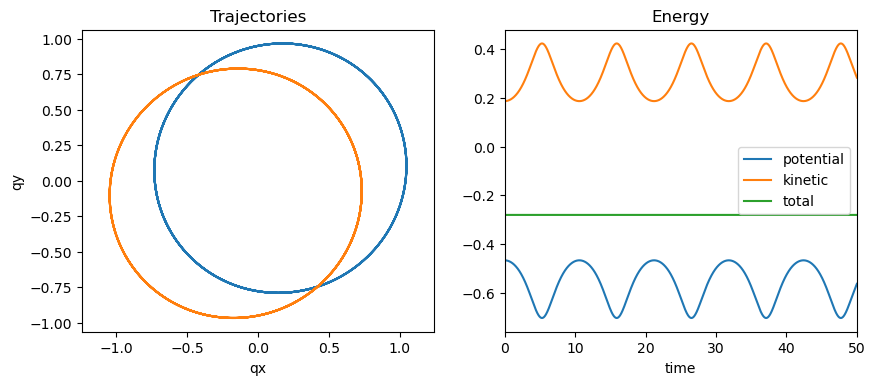

In [52]:
# draw true trajectories
fig = plt.figure(figsize = [10,4], dpi=100)
plt.subplot(1,2,1)
plt.title('Trajectories')
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], label='body {} path'.format(i))

plt.axis('equal')
plt.xlabel('qx') ; plt.ylabel('qy')

plt.subplot(1,2,2)
plt.title('Energy') ; plt.xlabel('time')
plt.plot(settings['t_eval'], potential_energy(orbit), label='potential')
plt.plot(settings['t_eval'], kinetic_energy(orbit), label='kinetic')
plt.plot(settings['t_eval'], total_energy(orbit), label='total')
plt.legend()
plt.xlim(*settings['t_span'])

plt.show()

In [116]:
# load trained baseline and HNN models
def load_model(baseline):
    output_dim = input_dim if baseline else 2
    nn_model = MLP(input_dim, hidden_dim, output_dim, nonlinearity)
    model = HNN(input_dim, differentiable_model=nn_model,
            field_type=field_type, baseline=baseline)
    
    case = 'baseline' if baseline else 'hnn'
    path = "{}/{}-orbits-{}.tar".format(save_dir, name, case)
    model.load_state_dict(torch.load(path))
    return model

base_model = load_model(baseline=True)
hnn_model = load_model(baseline=False)

In [40]:
# integrating a vector field parameterized by a NN or HNN
# output is deriv = 8-element array with q, p derivatives
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,2).T
    return deriv.reshape(-1)

### Baseline Model Results

In [43]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

# integrate orbit using baseline model
update_fn = lambda t, y0: model_update(t, y0, base_model)
base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

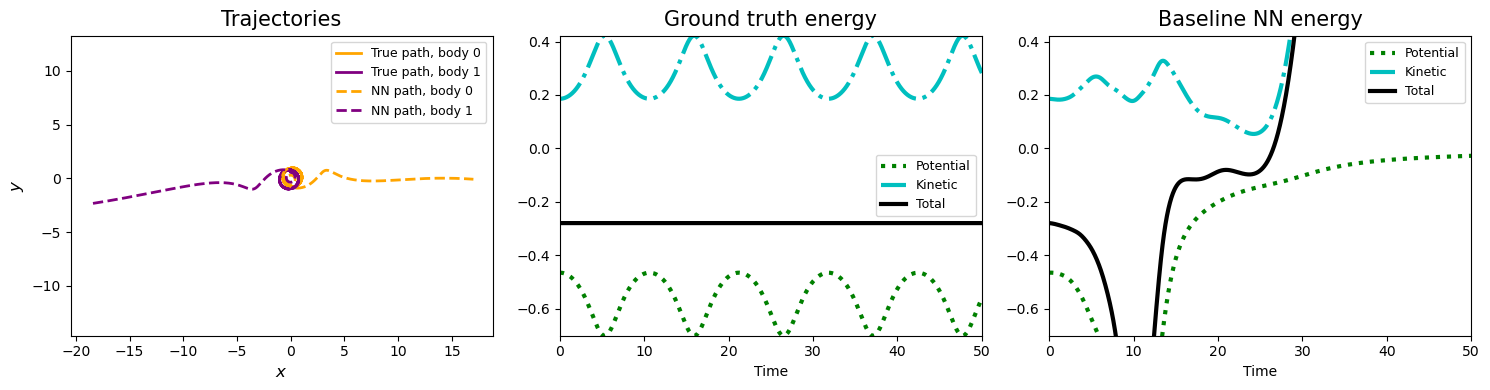

In [45]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(base_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(base_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(base_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(base_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

### HNN Results

In [111]:
np.random.seed(2)
t_points = 2000
t_span = [0,50]
state = random_config()

orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)

# integrate orbit with using HNN
update_fn = lambda t, y0: model_update(t, y0, hnn_model)
hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)

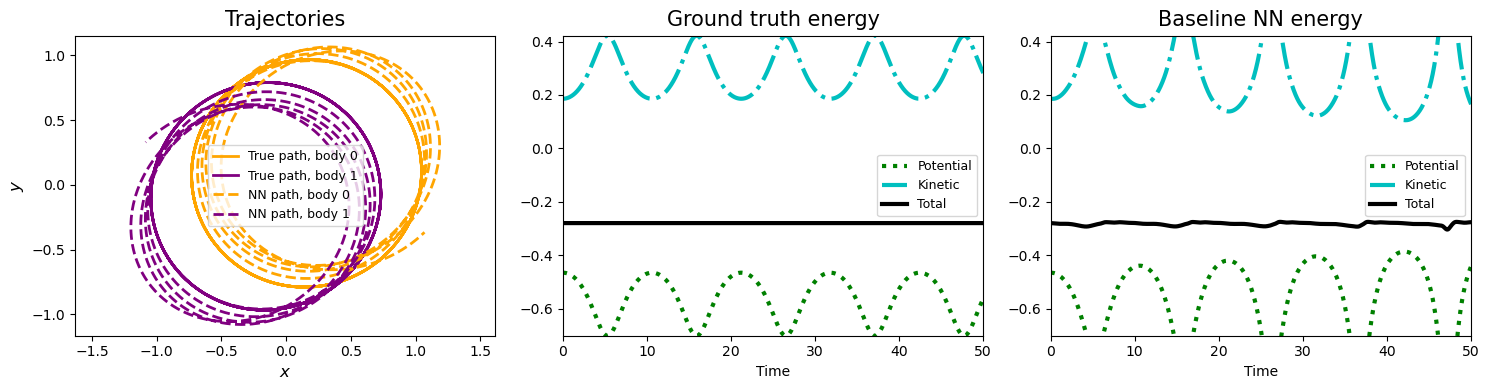

In [117]:
lw = 3 #linewidth
fs=9
ts=15
tpad = 7
ls=12

fig = plt.figure(figsize=[15,4], dpi=100)
plt.subplot(1,3,1)
plt.title('Trajectories', fontsize=ts, pad=tpad)
colors = ['orange', 'purple']
for i, path in enumerate(orbit):
    plt.plot(path[1], path[2], '-', c=colors[i], label='True path, body {}'.format(i), linewidth=2)
    
for i, path in enumerate(hnn_orbit):
    plt.plot(path[1], path[2], '--', c=colors[i], label='NN path, body {}'.format(i), linewidth=2)

plt.axis('equal')
plt.xlabel('$x$', fontsize=ls) ; plt.ylabel('$y$', fontsize=ls)
plt.legend(fontsize=fs)

plt.subplot(1,3,2)
real_pe, real_ke, real_etot = potential_energy(orbit), kinetic_energy(orbit), total_energy(orbit)
plt.title('Ground truth energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], real_pe, 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], real_ke, 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], real_etot, 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
ymin = np.min([real_pe.min(), real_ke.min(), real_etot.min()])
ymax = np.max([real_pe.max(), real_ke.max(), real_etot.max()])
plt.ylim(ymin, ymax)

plt.subplot(1,3,3)
plt.title('Baseline NN energy', fontsize=ts, pad=tpad)
plt.xlabel('Time')
plt.plot(settings['t_eval'], potential_energy(hnn_orbit), 'g:', label='Potential', linewidth=lw)
plt.plot(settings['t_eval'], kinetic_energy(hnn_orbit), 'c-.', label='Kinetic', linewidth=lw)
plt.plot(settings['t_eval'], total_energy(hnn_orbit), 'k-', label='Total', linewidth=lw)
plt.legend(fontsize=fs)
plt.xlim(*settings['t_span'])
plt.ylim(ymin, ymax)

plt.tight_layout() ; plt.show()

### Check how well HNN conserves its scalar output and also energy

In [118]:
# integrate trajectories
t_points = 100
t_span = [0,10]
num_orbits = 50
update_fn = lambda t, y0: model_update(t, y0, hnn_model)

orbits = []
energies = []
total_energies = []
for i in range(num_orbits):
    np.random.seed(i)
    state = random_config()
    mini_orbit, _ = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    total_energies.append(total_energy(mini_orbit).squeeze())
    orbits.append(mini_orbit)
    
    # convert from state to canonical coords
    np_coords = mini_orbit[:,1:,:].transpose(1,0,2).reshape(8, -1).T
    coords = torch.tensor( np_coords, requires_grad=True, dtype=torch.float32)
    F1, F2 = hnn_model.forward(coords)
    energies.append(F2.data.numpy().squeeze())

total_energies = np.stack(total_energies)
te_order = np.argsort(total_energies.mean(1))
total_energies = total_energies[te_order]
energies = np.stack(energies)
e_order = np.argsort(energies.mean(1))
energies = energies[e_order]

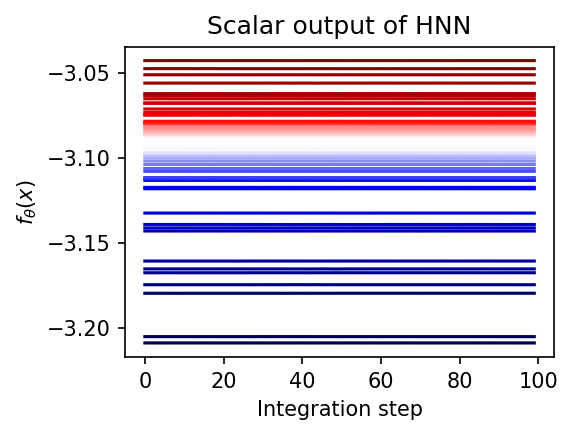

In [119]:
fig = plt.figure(figsize=[4,3], dpi=150)
plt.subplot(1,1,1)

import matplotlib.pylab as pl
colors = pl.cm.seismic(np.linspace(0,1,num_orbits))
for i, e in enumerate(energies):
    plt.plot(e, color=colors[i])
    
plt.xlabel('Integration step')
plt.ylabel('$f_{\\theta}(x)$')
plt.title("Scalar output of HNN")
plt.tight_layout() ; plt.show()

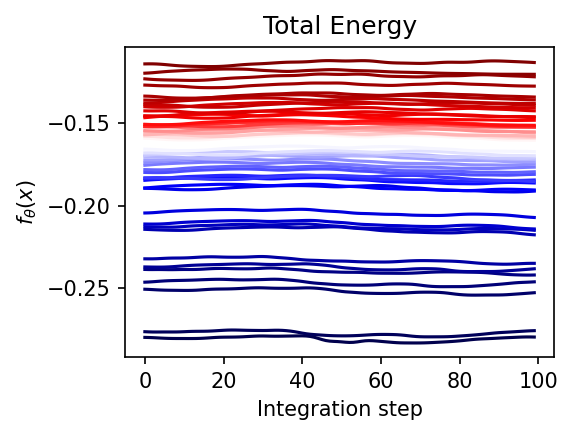

In [120]:
fig = plt.figure(figsize=[4,3], dpi=150)
plt.subplot(1,1,1)

import matplotlib.pylab as pl
colors = pl.cm.seismic(np.linspace(0,1,num_orbits))
for i, e in enumerate(total_energies):
    plt.plot(e, color=colors[i])
    
plt.xlabel('Integration step')
plt.ylabel('$f_{\\theta}(x)$')
plt.title("Total Energy")
plt.tight_layout() ; plt.show()

### Energy Conservation of HNN vs Baseline

In [121]:
t_points = 500
t_span = [0,25]
trials = 5*3

true_energies, base_energies, hnn_energies = [], [], []
for trial_ix in range(trials):
    
    np.random.seed(trial_ix)
    state = random_config()
    
    # true trajectory -> energy
    orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span)
    true_energies.append(total_energy(orbit))
    
    # baseline NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, base_model)
    base_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    base_energies.append(total_energy(base_orbit))
    
    # hamiltonian NN trajectory -> energy
    update_fn = lambda t, y0: model_update(t, y0, hnn_model)
    hnn_orbit, settings = get_orbit(state, t_points=t_points, t_span=t_span, update_fn=update_fn)
    hnn_energies.append(total_energy(hnn_orbit))
    
true_energies = np.stack(true_energies)
base_energies = np.stack(base_energies)
hnn_energies = np.stack(hnn_energies)

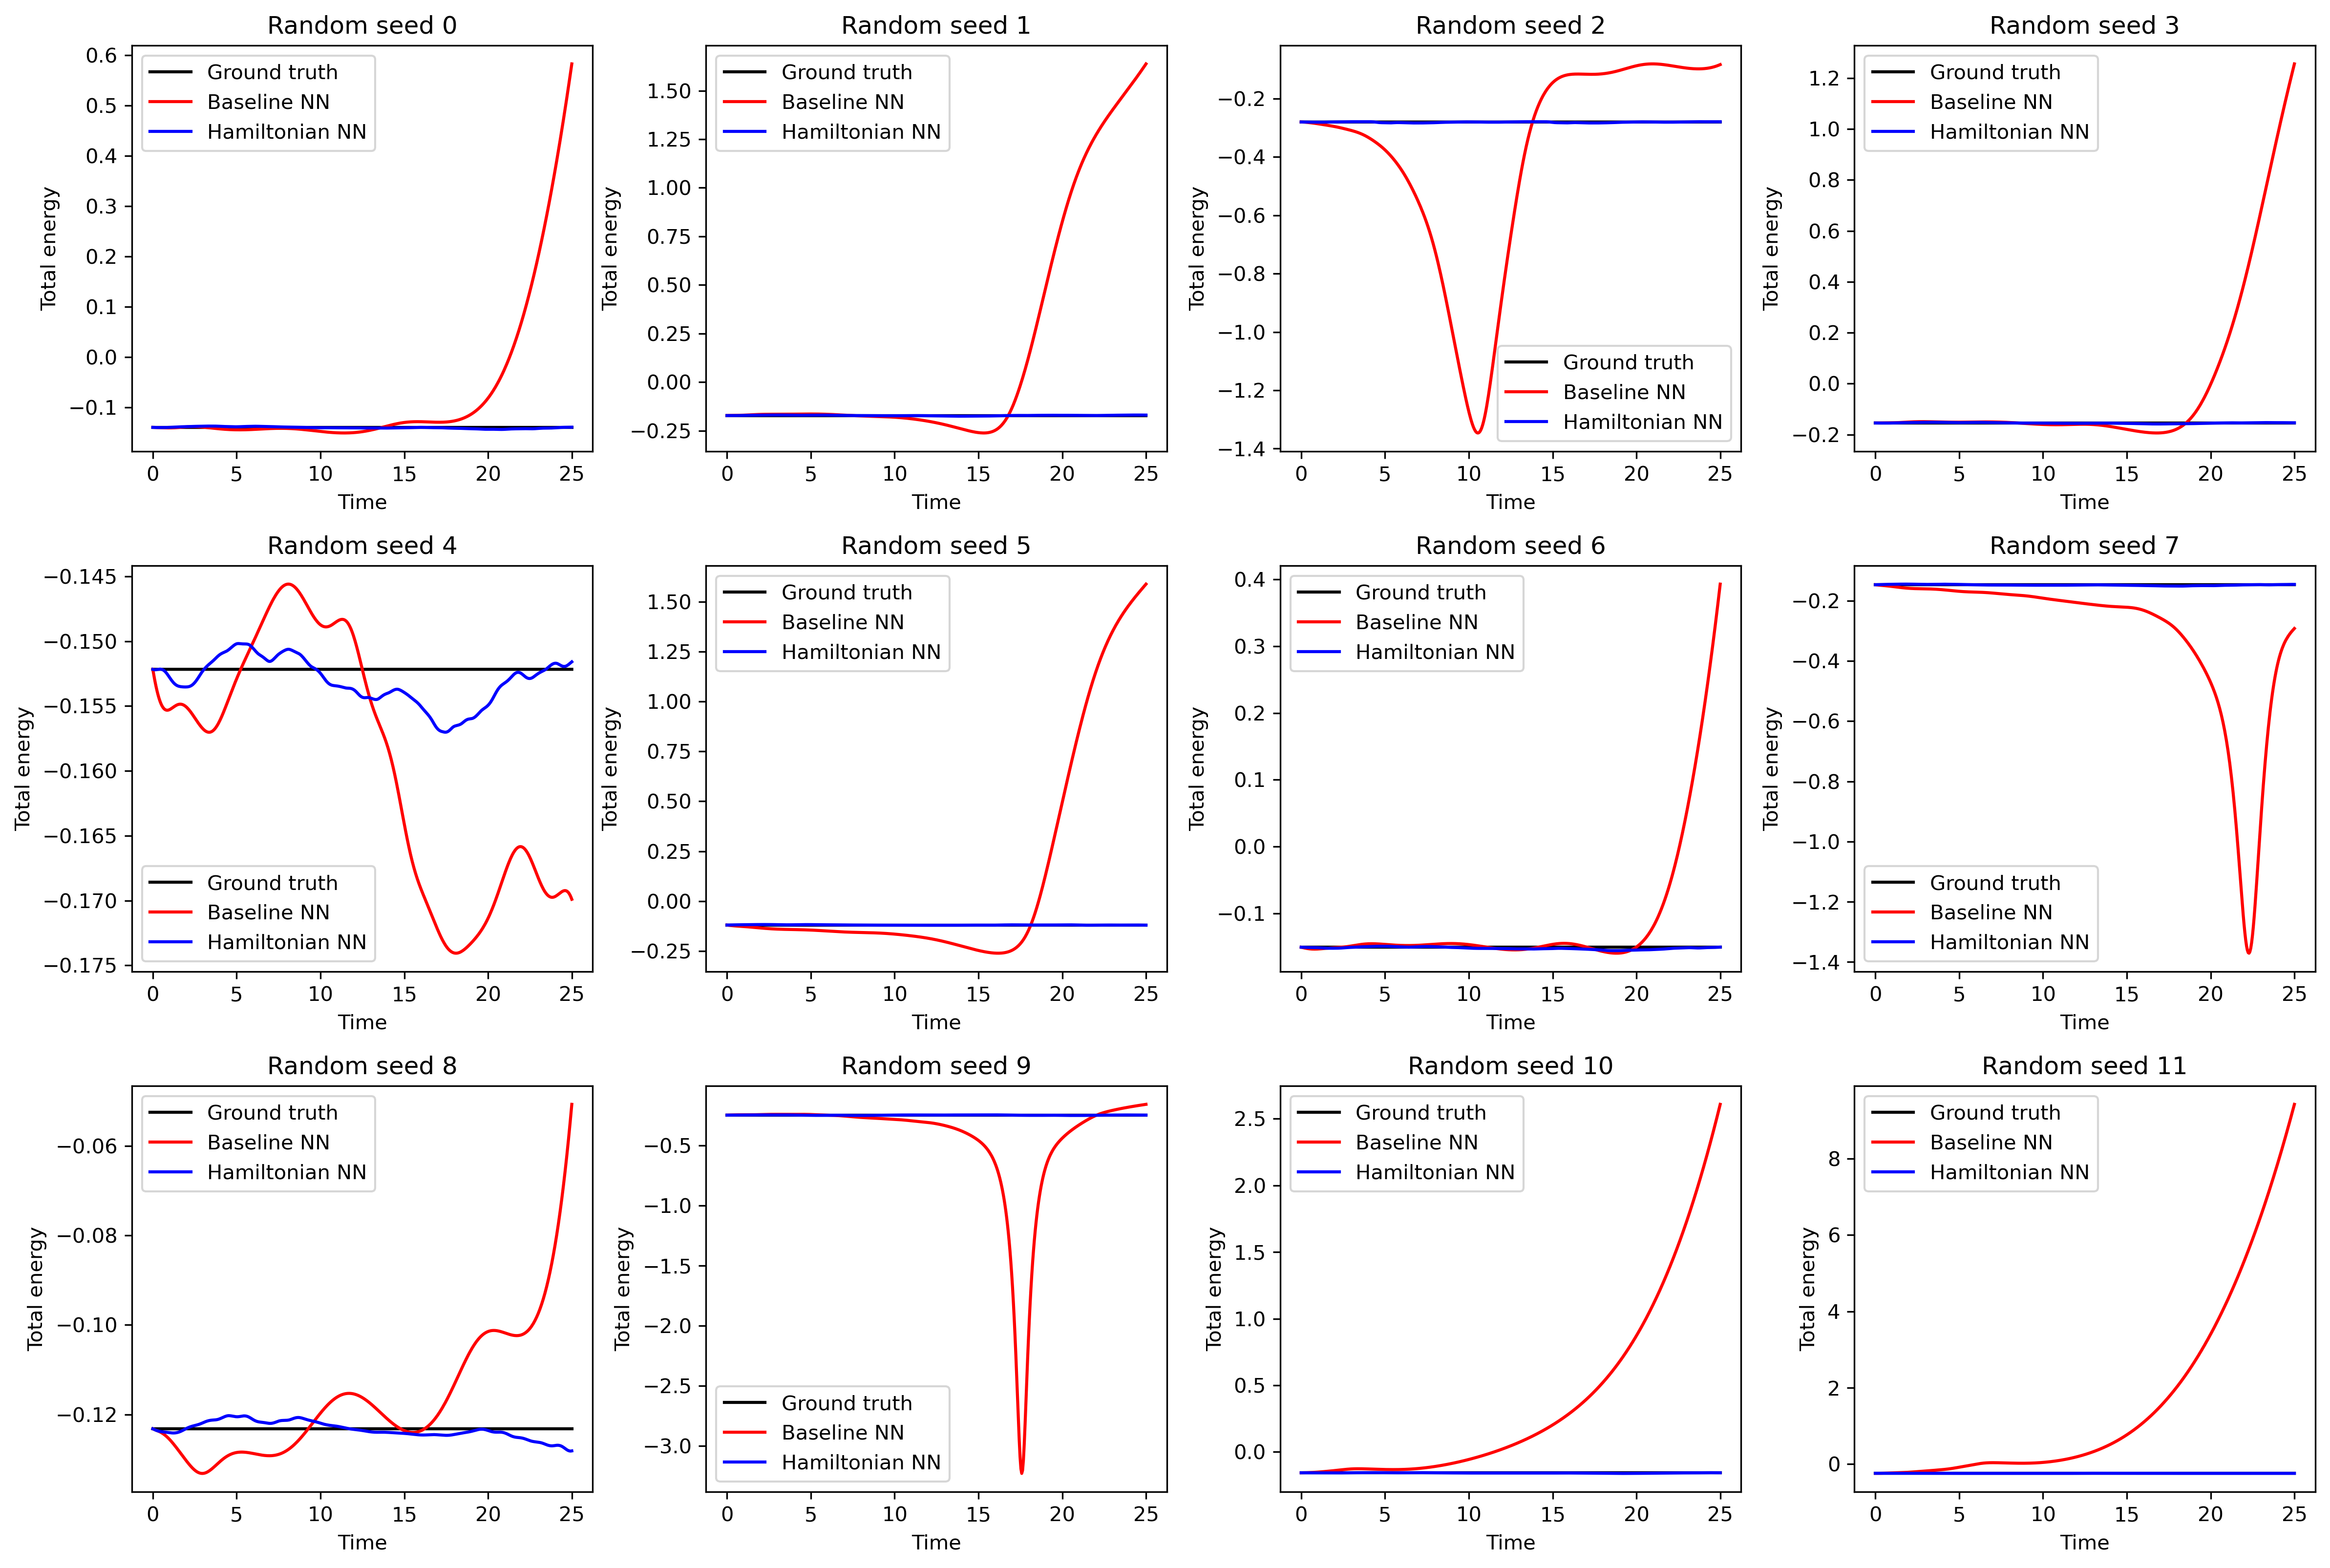

In [123]:
rows, cols = 3, 4
N = rows*cols
s = 4
fig = plt.figure(figsize=[cols*s, .9*rows*s], dpi=300)
for i in range(N):
    
    plt.subplot(rows, cols,i+1)
    t_domain = np.linspace(t_span[0], t_span[1], t_points)
    plt.title('Random seed {}'.format(i))
    plt.plot(t_domain, true_energies[i], 'k-', label='Ground truth')
    plt.plot(t_domain, base_energies[i], 'r-', label='Baseline NN')
    plt.plot(t_domain, hnn_energies[i], 'b-', label='Hamiltonian NN')
    plt.xlabel('Time')
    plt.ylabel('Total energy')
    plt.legend()
    
plt.tight_layout() ; plt.show()